### Mean-shift를 이용한 눈동자 검출 방법

![meanshift](https://aiffelstaticprd.blob.core.windows.net/media/original_images/10_BHmd9aH.png)  
1. #### 이미지 중심점을 초기값으로 설정하겠습니다.  
눈의 중심에 눈동자가 있을 확률이 높기 때문에 초기값으로 정하기에 아주 좋습니다.)
2. #### 중심점을 기준으로 작은 box를 설정합니다.  
box의 크기는 문제에 따라 적절한 값을 설정해야 합니다.  
그림에서 회색박스를 생각하시면 됩니다.  
3. #### box 내부의 pixel 값을 이용해서 '무게중심'을 찾습니다.  
이 때 무게중심은 pixel intensity를 weight 로 사용할 수 있습니다.  
4. #### 찾은 무게중심을 새로운 box의 중심으로 설정합니다.  
이 단계에서 박스가 이동하게 됩니다. 이제 회색박스에서 초록색박스로 관심영역이 이동했습니다.  
5. #### 다시 초록색 박스를 기준으로 2-4를 반복합니다.  
6. #### 중심점이 수렴할 때 까지 2~5를 반복하면 수렴한 점의 위치로 눈동자를 찾을 수 있습니다.  
  
- [영상추적#1 - Mean Shift 추적](https://darkpgmr.tistory.com/64)

In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib
import argparse

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('show_substep', type=str2bool, nargs='?', default=False)

config = args.parse_args()



img = cv2.imread('./images/image.png')
print (img.shape)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for idx, point in enumerate(list_points):
    cv2.circle(img_rgb, point, 3, (255, 255, 0), -1) # yellow

if config.show_substep:
    plt.imshow(img_rgb)
    plt.show()


def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()

    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl

    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6

    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

# 눈 이미지 crop
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape) # (26, 47, 3)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
    plt.show()


# 눈 이미지에서 중심을 찾는 함수
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    # x 축 center 를 찾는 알고리즘을 mean shift 로 대체합니다.
    # center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    # 수정된 부분
    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1

    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]

# 눈동자 검출 wrapper 함수
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

# 눈동자 중심 좌표 출력
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

# 이미지 출력
show = img_right_eye.copy()

show = cv2.circle(show, (right_center_x, right_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

#### 코드 설명
- 눈 이미지를 low pass filter를 이용해서 smoothing한 후 bilateral filter를 이용
- 1차원 값으로 누적시킨 후 y 축 기준으로 최대값을 찾아서 y축의 중심점 좌표를 찾아냄 
- x축은 1차원 최댓값 지점을 기준으로 mean shift를 수행하게 되는데 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력

#### 실행 코드
- cd ~/aiffel/coarse_to_fine && python eye_center_meanshift.py

### 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인
#### LFW 데이터셋으로부터 가공 생성
- cd ~/aiffel/coarse_to_fine && python prepare_eye_dataset.py

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [4]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23648 23648
Found 23648 images belonging to 1 classes.
Found 23648 images belonging to 1 classes.


In [5]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

#### 코드설명
- 학습 라벨을 만들 때 3개의 점을 label 이미지에 표시했다. 눈의 왼쪽 끝점을 1의 값으로, 오른쪽 끝점은 2의 값으로, 가장 중요한 눈 중심(눈동자)는 3으로 인코딩. np.where() 함수로 이미지에서 좌표로 복원

In [7]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.        0.        1.        1.        0.0414548 0.35625  ]
(80, 120, 3) [0.         0.         1.         1.         0.24583334 0.15598404]


/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


- 120x80의 정해진 크기로 이미지가 잘 출력되고 라벨 또한 0~1 값으로 정규화(normalize) 되어 있는 것을 확인

### 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계

In [8]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

- 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 loss와 metric을 각각 mse 와 mae 로 설정하여 mae 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습가능함.

In [10]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

- 학습률(learning rate)을 조절하는 함수. 지수적으로 감소하게 만듦.

In [11]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23648 32 739
Epoch 1/10


/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


739/739 [==============================] - 120s 163ms/step - loss: 0.0192 - mae: 0.0686
Epoch 2/10
739/739 [==============================] - 120s 163ms/step - loss: 0.0142 - mae: 0.0560
Epoch 3/10
739/739 [==============================] - 118s 159ms/step - loss: 0.0137 - mae: 0.0545
Epoch 4/10
739/739 [==============================] - 118s 160ms/step - loss: 0.0132 - mae: 0.0533
Epoch 5/10
739/739 [==============================] - 115s 156ms/step - loss: 0.0131 - mae: 0.0530
Epoch 6/10
739/739 [==============================] - 113s 153ms/step - loss: 0.0130 - mae: 0.0526
Epoch 7/10
739/739 [==============================] - 113s 153ms/step - loss: 0.0129 - mae: 0.0524
Epoch 8/10
739/739 [==============================] - 113s 153ms/step - loss: 0.0128 - mae: 0.0521
Epoch 9/10
739/739 [==============================] - 113s 153ms/step - loss: 0.0128 - mae: 0.0521
Epoch 10/10
739/739 [==============================] - 117s 159ms/step - loss: 0.0127 - mae: 0.0519


### 키포인트 검출 딥러닝 모델 만들기 (3) 평가

In [13]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2637 images belonging to 1 classes.
Found 2636 images belonging to 1 classes.


In [14]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012948504649102688 0.05223365128040314


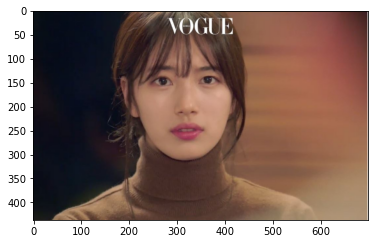

In [15]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/face.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

- 입력을 위해 이미지를 120x80 으로 resize 한 후, 배치(batch)를 나타낼 수 있는 4차원 텐서로 변경

In [16]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.3247447e-06 2.3878983e-06]
  [1.2000000e+02 8.0000000e+01]
  [5.0801151e+01 2.3989475e+01]]]


[0. 0.]
[120.  80.]
[51. 24.]


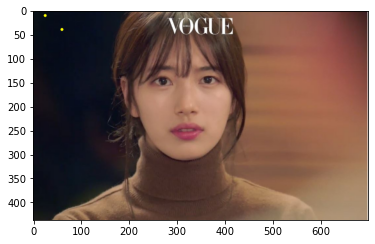

In [17]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

#### 모델이 눈을 제대로 찾지 못하여 합성을 하기가 어렵다